In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimers/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimers//train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimers/test",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5125 files belonging to 4 classes.
Using 4100 files for training.
Found 5125 files belonging to 4 classes.
Using 1025 files for validation.
Found 1279 files belonging to 4 classes.


In [ ]:
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(4, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

In [ ]:
NUM_IMAGES = []

for label in classnames:
    dir_name = "/content/drive/MyDrive/Alzheimers/train/" + label[:-2] +'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

NUM_IMAGES,classnames

([717, 52, 2564, 1792],
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

In [ ]:
#Performing Image Augmentation to have more data samples
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
IMG_SIZE = 180
IMAGE_SIZE = [180, 180]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="/content/drive/MyDrive/Alzheimers/train"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)


Found 5125 images belonging to 4 classes.


In [ ]:
train_data, train_labels = train_data_gen.next()

KeyboardInterrupt: ignored

In [ ]:
print (train_data.shape, train_labels.shape)

(5125, 180, 180, 3) (5125, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced
#after oversampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10256, 180, 180, 3) (10256, 4)


In [ ]:
#Splitting the data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(input_shape=(180, 180, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
from tensorflow.keras.callbacks import ReduceLROnPlateau

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback]

custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 20

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)


Epoch 1/30
206/206 [==============================] - 652s 3s/step - loss: 1.4384 - acc: 0.4026 - auc: 0.6677 - val_loss: 0.8976 - val_acc: 0.5832 - val_auc: 0.8533 - lr: 0.0010
Epoch 2/30
206/206 [==============================] - 646s 3s/step - loss: 0.9224 - acc: 0.5793 - auc: 0.8449 - val_loss: 0.7006 - val_acc: 0.6697 - val_auc: 0.9059 - lr: 0.0010
Epoch 3/30
206/206 [==============================] - 641s 3s/step - loss: 0.7940 - acc: 0.6255 - auc: 0.8823 - val_loss: 0.6495 - val_acc: 0.6849 - val_auc: 0.9177 - lr: 0.0010
Epoch 4/30
206/206 [==============================] - 641s 3s/step - loss: 0.7125 - acc: 0.6687 - auc: 0.9059 - val_loss: 0.5850 - val_acc: 0.7307 - val_auc: 0.9357 - lr: 0.0010
Epoch 5/30
206/206 [==============================] - 639s 3s/step - loss: 0.6671 - acc: 0.6998 - auc: 0.9198 - val_loss: 0.5657 - val_acc: 0.7294 - val_auc: 0.9391 - lr: 0.0010
Epoch 6/30
206/206 [==============================] - 647s 3s/step - loss: 0.6318 - acc: 0.7195 - auc: 0.9276 

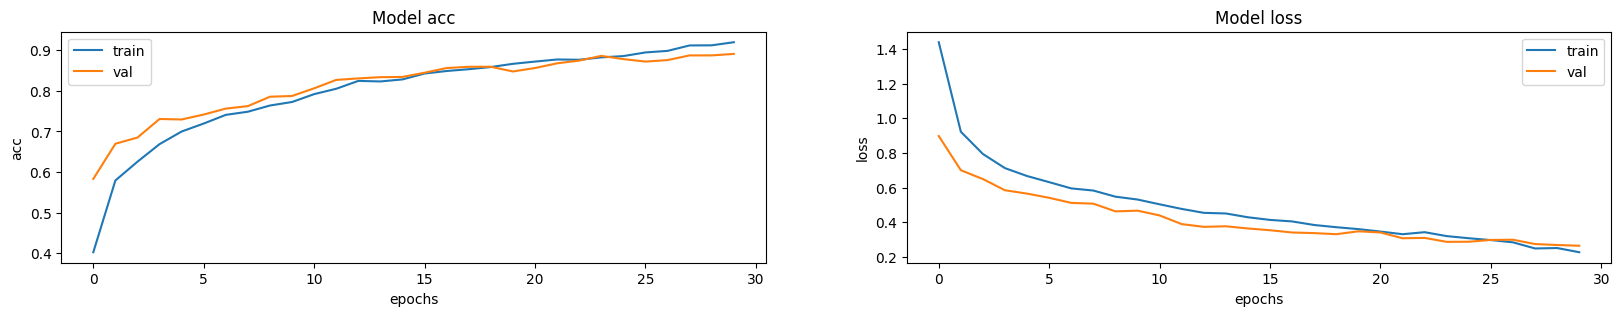

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

65/65 [==============================] - 128s 2s/step - loss: 0.3746 - acc: 0.8519 - auc: 0.9746
Testing Accuracy: 85.19%


In [ ]:
pred_labels = custom_inception_model.predict(test_data)

In [ ]:
#Plot the confusion matrix to understand the classification in detail
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
export_dir = '/kaggle/working/'
tf.saved_model.save(custom_inception_model, export_dir)
import pathlib
tflite_model_name = "alzahimer.tflite"
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
#save model as tflite for mobile app (Flutter)
tflite_model_file = pathlib.Path(tflite_model_name)
tflite_model_file.write_bytes(tflite_model)

23327632

In [ ]:
import tensorflow as tf
#save model as hdf5 for web app (streamlit)
tf.keras.models.save_model(custom_inception_model,'alzahimer.hdf5')